<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/Weight_Sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# dataset build

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-08 21:17:27--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-08 21:17:27--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  6.22MB/s    in 16s     

2021-03-08 21:17:44 (2.08 MB/s) - ‘MNIST.tar.gz’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

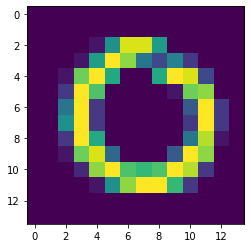

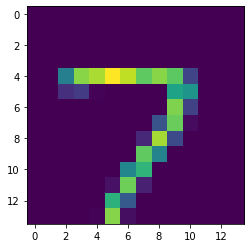

train shape : torch.Size([1000, 2, 14, 14])


In [7]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [8]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [9]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


# Models

## FullyDenseNN

In [63]:
class FullyDenseNet(nn.Module):
    def __init__(self):
        super(FullyDenseNet, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

## CNN_model

In [118]:
class CNN_model1(nn.Module):
  def __init__(self):
        super(CNN_model1, self).__init__()
        self.conv1 = nn.Conv2d(2, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 6 , kernel_size=3)

        self.fc1 = nn.Linear(6*10*10, 100)
        self.fc2 = nn.Linear(100, 1)


  def forward(self, x):


        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        x = nn.Flatten(1)(x)        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 

        return torch.sigmoid(x)

## CNN Model 2

In [153]:
class CNN_model2(nn.Module):
  def __init__(self):
        super(CNN_model2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 6 , kernel_size=3)

        self.fc1 = nn.Linear(1200, 100)
        self.fc2 = nn.Linear(100, 1)


  def forward(self, x):

        # I hate this , how do u make it batch independent ? should be like : x_l = x[0,:,:]
        x_l = x[:,0,:,:]
        x_r = x[:,1,:,:]

        x_l = x_l.view(x_l.shape[0] , 1, 14,14)
        x_r = x_r.view(x_r.shape[0] , 1, 14,14)

        x_l = torch.relu(self.conv1(x_l))
        x_l = torch.relu(self.conv2(x_l))

        x_r = torch.relu(self.conv1(x_r))
        x_r = torch.relu(self.conv2(x_r))

        x_r = nn.Flatten(1)(x_r)   
        x_l = nn.Flatten(1)(x_l)  

        x = torch.cat((x_r, x_l), 1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 

        return torch.sigmoid(x)

# Train tools

In [149]:
def train_epoch(network_ , optimizer_ , criterion = F.binary_cross_entropy ):
  loss_tot = []
  acc_tot = []
  network_.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer_.zero_grad()
    output = network_(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer_.step()

    loss_tot.append(loss.item())
    acc_tot.append( (target == torch.round(output) ).sum().item() )
  
  return torch.FloatTensor(loss_tot).mean().item() , torch.FloatTensor(acc_tot).mean().item()/100.0

In [23]:
def test(network_ , criterion_ = F.binary_cross_entropy):
  network_.eval()
  test_loss = 0
  acc = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network_(data)
      test_loss += criterion_(output.flatten(), target.to(torch.float32)).item()
      acc += (target == torch.round(output.flatten()) ).sum().item()

  test_loss /= len(test_dataloader)
  acc /= len(test_dataloader)
  return test_loss , acc/100.0

In [24]:
def train(network_ , optimizer_ , criterion_ = F.binary_cross_entropy ,epoch_nb = 30,   debug_ = True):

  tot_train_loss = []
  tot_train_acc = []
  tot_test_loss = []
  tot_test_acc = []


  for epoch in range(epoch_nb):
    train_loss , train_acc = train_epoch(network_ , optimizer_ , criterion_)
    test_loss , test_acc = test(network_ , criterion_)

    tot_train_loss.append(train_loss)
    tot_train_acc.append(train_acc)
    tot_test_loss.append(test_loss)
    tot_test_acc.append(test_acc)

    if(debug_):
      print(epoch, train_loss , train_acc , test_loss , test_acc)

  return tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc

# stats

In [14]:
def train_multiple_runs( network_class , runs = 10 , epoch = 30):
  all_train_loss , all_train_acc , all_test_loss , all_test_acc = [],[],[],[]
  
  for i in range(runs):
    n = network_class()
    optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.5)
    criterion = F.binary_cross_entropy

    tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc = train(n , optimizer , criterion , epoch , debug_ = False)
    all_train_loss.append(tot_train_loss)
    all_train_acc.append(tot_train_acc)
    all_test_loss.append(tot_test_loss)
    all_test_acc.append(tot_test_acc)

  return all_train_loss , all_train_acc , all_test_loss , all_test_acc

In [15]:
def plot_loss_acc( tot_train_loss , tot_train_acc , tot_test_loss , tot_test_acc ):
  epochs = range(1, len(tot_train_loss)+1 )
  plt.plot(epochs, tot_train_loss, 'g', label='Training loss')
  plt.plot(epochs, tot_test_loss, 'b', label='Test loss')
  plt.plot(epochs, tot_train_acc, 'r', label='Training acc')
  plt.plot(epochs, tot_test_acc, 'y', label='Test acc')
  plt.title('Training and Test loss/acc')
  plt.xlabel('Epochs')
  plt.ylabel('loss/acc')
  plt.ylim((0,1))
  plt.legend()
  plt.show()

In [16]:
import numpy as np
def plot_std_loss_acc(all_train_loss , all_train_acc , all_test_loss , all_test_acc):
  trl_mean = np.array(all_train_loss).mean(axis = 0)
  tel_mean = np.array(all_train_acc).mean(axis = 0)
  tra_mean = np.array(all_test_loss).mean(axis = 0)
  tea_mean = np.array(all_test_acc).mean(axis = 0)

  trl_std = np.array(all_train_loss).std(axis = 0)
  tel_std = np.array(all_train_acc).std(axis = 0)
  tra_std = np.array(all_test_loss).std(axis = 0)
  tea_std = np.array(all_test_acc).std(axis = 0)

  epochs = range(1, len(tea_std)+1 )

  temp = [ [trl_mean , trl_std] , [tel_mean , tel_std] , [tra_mean , tra_std] , [tea_mean , tea_std] ]

  for g in temp : 
    plt.plot( epochs , g[0] )
    plt.fill_between(epochs, g[0]-g[1], g[0]+g[1] ,alpha=0.3)

  plt.ylim((-0.1,1.1))


# PLAYGROUND

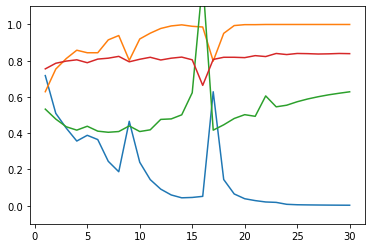

In [129]:
a,b,c,d = train_multiple_runs( FullyDenseNet , runs = 1 , epoch = 30)
plot_std_loss_acc(a,b,c,d)

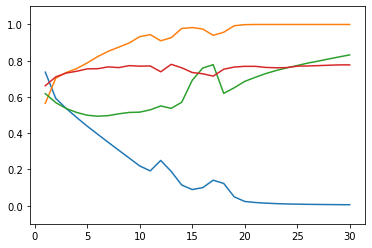

In [130]:
a,b,c,d = train_multiple_runs( CNN_model1 , runs = 1 , epoch = 30)
plot_std_loss_acc(a,b,c,d)

In [157]:
n = CNN_model2()
optimizer = optim.SGD(n.parameters(), lr=0.001, momentum=0.5)
criterion = F.binary_cross_entropy

_,_,_,_ = train(n,optimizer, epoch_nb=30)

del n , optimizer , criterion

0 0.9431501626968384 0.5409999847412109 0.6624147355556488 0.627
1 0.5912103056907654 0.6869999694824219 0.5804959446191787 0.688
2 0.5105010271072388 0.745999984741211 0.5397192895412445 0.721
3 0.46137818694114685 0.78 0.51413514316082 0.7340000000000001
4 0.4260109066963196 0.8130000305175781 0.4984599232673645 0.745
5 0.39765089750289917 0.8290000152587891 0.4890988290309906 0.7509999999999999
6 0.3736110329627991 0.8430000305175781 0.4819082260131836 0.758
7 0.3521307408809662 0.8569999694824219 0.47732614576816557 0.7609999999999999
8 0.3324241042137146 0.8719999694824219 0.4733900547027588 0.764
9 0.3142440915107727 0.8859999847412109 0.47132361829280855 0.7709999999999999
10 0.2974017858505249 0.8930000305175781 0.468922758102417 0.774
11 0.2817964553833008 0.899000015258789 0.4686205327510834 0.774
12 0.26729676127433777 0.9069999694824219 0.4683503478765488 0.778
13 0.2536115050315857 0.9180000305175782 0.4675432533025742 0.779
14 0.24050848186016083 0.9259999847412109 0.4697